In [1]:
import mxnet as mx
import gluonnlp as nlp

import matplotlib.pyplot as plt
import numpy as np
import os
import random
import sacremoses
import time
from tqdm.notebook import tqdm

# Local Libraries
import nmt
import dataprocessor
import utils
import nmt.transformer_hparams

# Seeds for reproducibility
np.random.seed(100)
random.seed(100)
mx.random.seed(10000)

# CPU setup
# ctx = mx.cpu()
# Single GPU setup
ctx = mx.gpu(0)

[nltk_data] Downloading package punkt to /home/andreto/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/andreto/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/andreto/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# IWSLT2015 Dataset (Train, Validation and Test)

# Dataset Parameters
src_lang, tgt_lang = "vi", "en"
src_max_len, tgt_max_len = 50, 50

iwslt_train_text = nlp.data.IWSLT2015("train",
                                      src_lang=src_lang,
                                      tgt_lang=tgt_lang)

iwslt_val_text   = nlp.data.IWSLT2015("val",
                                      src_lang=src_lang,
                                      tgt_lang=tgt_lang)

iwslt_test_text  = nlp.data.IWSLT2015("test",
                                      src_lang=src_lang,
                                      tgt_lang=tgt_lang)


iwslt_src_vocab = iwslt_train_text.src_vocab
iwslt_tgt_vocab = iwslt_train_text.tgt_vocab

/home/andreto/.local/lib/python3.7/site-packages/gluonnlp/vocab/vocab.py:591: UserWarning: Detected a corrupted index in the deserialize vocabulary. For versions before GluonNLP v0.7 the index is corrupted by specifying the same token for different special purposes, for example eos_token == padding_token. Deserializing the vocabulary nevertheless.
  'Detected a corrupted index in the deserialize vocabulary. '


In [3]:
print("Length of train set:", len(iwslt_train_text))
print("Length of val set  :", len(iwslt_val_text))
print("Length of test set :", len(iwslt_test_text))

Length of train set: 133166
Length of val set  : 1553
Length of test set : 1268


In [4]:
# Dataset processing: clipping, tokenizing, indexing and adding of EOS (src/tgt) / BOS (tgt)
iwslt_train_processed = iwslt_train_text.transform(
    dataprocessor.TrainValDataTransform(
        iwslt_src_vocab,
        iwslt_tgt_vocab,
        src_max_len,
        tgt_max_len),
    lazy=False)

iwslt_val_processed   = iwslt_val_text.transform(
    dataprocessor.TrainValDataTransform(
        iwslt_src_vocab,
        iwslt_tgt_vocab,
        src_max_len,
        tgt_max_len),
    lazy=False)

iwslt_test_processed  = iwslt_test_text.transform(
    dataprocessor.TrainValDataTransform(
        iwslt_src_vocab,
        iwslt_tgt_vocab,
        src_max_len,
        tgt_max_len),
    lazy=False)

In [5]:
# Target Sequences (Val, Test)
fetch_tgt_sentence = lambda src, tgt: tgt.split()
val_tgt_sentences = list(iwslt_val_text.transform(fetch_tgt_sentence))
test_tgt_sentences = list(iwslt_test_text.transform(fetch_tgt_sentence))

In [6]:
# Create Gluon Datasets
# Not needed for training, as training data will be sharded later
iwslt_train_transformed = iwslt_train_processed.transform(
    lambda src, tgt: (src, tgt, len(src), len(tgt)),
    lazy=False)

iwslt_val_dataset = mx.gluon.data.SimpleDataset(
    [(ele[0], ele[1], len(ele[0]), len(ele[1]),i) for i, ele in enumerate(iwslt_val_processed)])

iwslt_test_dataset = mx.gluon.data.SimpleDataset(
    [(ele[0], ele[1], len(ele[0]), len(ele[1]), i) for i, ele in enumerate(iwslt_test_processed)])

In [7]:
# Hyperparameters for Dataloaders and Training
hparams = nmt.transformer_hparams

In [8]:
hparams.num_hidden = 512
hparams.num_layers = 4
hparams.dropout = 0.2
hparams.num_buckets = 5
hparams.lr = 0.0001
#hparams.lr = 0.0001
#hparams.lr = 0.0003 achieves 21.44 test_bleu: qualitative evaluation didn't work
#hparams.lr = 0.0001 achieves 19.66 test_bleu: qualitative evaluation worked
hparams.clip = 5
hparams.epochs = 12
hparams.beam_size = 10
hparams.lp_alpha = 1.0
hparams.lp_k = 5

hparams.max_length = 150

In [9]:
# Create Gluon Samplers and DataLoaders

# Helper function for lengths
def get_data_lengths(dataset):
    get_lengths = lambda *args: (args[2], args[3])
    return list(dataset.transform(get_lengths))

# Bucket scheme
bucket_scheme = nlp.data.ExpWidthBucket(bucket_len_step=1.2)

iwslt_train_lengths = get_data_lengths(iwslt_train_transformed)
iwslt_val_lengths = get_data_lengths(iwslt_val_dataset)
iwslt_test_lengths = get_data_lengths(iwslt_test_dataset)

train_batchify_fn = nlp.data.batchify.Tuple(
    nlp.data.batchify.Pad(),
    nlp.data.batchify.Pad(),
    nlp.data.batchify.Stack(dtype='float32'),
    nlp.data.batchify.Stack(dtype='float32'))

test_batchify_fn = nlp.data.batchify.Tuple(
    nlp.data.batchify.Pad(),
    nlp.data.batchify.Pad(),
    nlp.data.batchify.Stack(dtype='float32'),
    nlp.data.batchify.Stack(dtype='float32'),
    nlp.data.batchify.Stack())

target_val_lengths = list(map(lambda x: x[-1], iwslt_val_lengths))
target_test_lengths = list(map(lambda x: x[-1], iwslt_test_lengths))

train_batch_sampler = nlp.data.FixedBucketSampler(
    lengths=iwslt_train_lengths,
    batch_size=hparams.batch_size,
    num_buckets=hparams.num_buckets,
    ratio=0,
    shuffle=True,
    use_average_length=False,
    num_shards=0,
    bucket_scheme=bucket_scheme)
    
train_data_loader = nlp.data.ShardedDataLoader(
    iwslt_train_transformed,
    batch_sampler=train_batch_sampler,
    batchify_fn=train_batchify_fn,
    num_workers=8)

val_batch_sampler = nlp.data.FixedBucketSampler(
    lengths=iwslt_val_lengths,
    batch_size=hparams.test_batch_size,
    num_buckets=hparams.num_buckets,
    ratio=0,
    shuffle=False,
    use_average_length=False,
    bucket_scheme=bucket_scheme)

val_data_loader = mx.gluon.data.DataLoader(
    iwslt_val_dataset,
    batch_sampler=val_batch_sampler,
    batchify_fn=test_batchify_fn,
    num_workers=8)

test_batch_sampler = nlp.data.FixedBucketSampler(
    lengths=iwslt_test_lengths,
    batch_size=hparams.test_batch_size,
    num_buckets=hparams.num_buckets,
    ratio=0,
    shuffle=False,
    use_average_length=False,
    bucket_scheme=bucket_scheme)

test_data_loader = mx.gluon.data.DataLoader(
    iwslt_test_dataset,
    batch_sampler=test_batch_sampler,
    batchify_fn=test_batchify_fn,
    num_workers=8)

/home/andreto/.local/lib/python3.7/site-packages/gluonnlp/data/batchify/batchify.py:235: UserWarning: Padding value is not given and will be set automatically to 0 in data.batchify.Pad(). Please check whether this is intended (e.g. value of padding index in the vocabulary).
  'Padding value is not given and will be set automatically to 0 '


In [10]:
# Transformer Model
transformer_encoder, transformer_decoder, transformer_one_step_ahead_decoder = nlp.model.transformer.get_transformer_encoder_decoder(
    hidden_size=hparams.num_hidden,
    dropout=hparams.dropout,
    num_layers=hparams.num_layers)

transformer_model = nlp.model.translation.NMTModel(
    src_vocab=iwslt_src_vocab,
    tgt_vocab=iwslt_tgt_vocab,
    encoder=transformer_encoder,
    decoder=transformer_decoder,
    one_step_ahead_decoder=transformer_one_step_ahead_decoder,
    #embed_size=hparams.num_hidden,
    embed_size=hparams.num_units,
    prefix='transformer_')

transformer_model.initialize(init=mx.init.Xavier(magnitude=1.0), ctx=ctx)
static_alloc = True
transformer_model.hybridize(static_alloc=static_alloc)

In [11]:
# Translator (using model defined above)
transformer_translator = nmt.translation.BeamSearchTranslator(
    model=transformer_model,
    beam_size=hparams.beam_size,
    scorer=nlp.model.BeamSearchScorer(
        alpha=hparams.lp_alpha,
        K=hparams.lp_k),
    # max_length=150)
    max_length=50)

In [12]:
# Loss function
loss_function = nlp.loss.MaskedSoftmaxCELoss()
loss_function.hybridize(static_alloc=static_alloc)

In [13]:
# Let's train
trainer = mx.gluon.Trainer(transformer_model.collect_params(), hparams.optimizer, {'learning_rate': hparams.lr})

best_valid_bleu = 0.0

train_losses = []
valid_losses = []
valid_bleus  = []
valid_perplexities = []

for epoch_id in tqdm(range(hparams.epochs)):

    log_loss = 0
    log_denom = 0
    log_avg_gnorm = 0
    log_wc = 0
    log_start_time = time.time()
    
    for batch_id, (src_seq, tgt_seq, src_valid_length, tgt_valid_length) in enumerate(tqdm(train_data_loader)):
        
        src_seq = src_seq.as_in_context(ctx)
        tgt_seq = tgt_seq.as_in_context(ctx)
        src_valid_length = src_valid_length.as_in_context(ctx)
        tgt_valid_length = tgt_valid_length.as_in_context(ctx)
        
        with mx.autograd.record():
            out, _ = transformer_model(
                src_seq,
                tgt_seq[:, :-1],
                src_valid_length,
                tgt_valid_length - 1)

            loss = loss_function(out, tgt_seq[:, 1:], tgt_valid_length - 1).mean()
            loss = loss * (tgt_seq.shape[1] - 1)
            log_loss += loss * tgt_seq.shape[0]
            log_denom += (tgt_valid_length - 1).sum()
            loss = loss / (tgt_valid_length - 1).mean()
            loss.backward()
        
        grads = [p.grad(ctx) for p in transformer_model.collect_params().values() if p.grad_req != 'null']
        gnorm = mx.gluon.utils.clip_global_norm(grads, hparams.clip)
        trainer.step(1)
        
        src_wc = src_valid_length.sum().asscalar()
        tgt_wc = (tgt_valid_length - 1).sum().asscalar()
        log_loss = log_loss.asscalar()
        log_denom = log_denom.asscalar()
        log_avg_gnorm += gnorm
        log_wc += src_wc + tgt_wc
        
        train_loss = log_loss / log_denom
        
        if (batch_id + 1) % hparams.log_interval == 0:
            wps = log_wc / (time.time() - log_start_time)
            print("[Epoch {} Batch {}/{}] loss={:.4f}, ppl={:.4f}, gnorm={:.4f}, "
                         "throughput={:.2f}K wps, wc={:.2f}K"
                         .format(epoch_id, batch_id + 1, len(train_data_loader),
                                 train_loss,
                                 np.exp(log_loss / log_denom),
                                 log_avg_gnorm / hparams.log_interval,
                                 wps / 1000, log_wc / 1000))
            
            log_start_time = time.time()
            log_loss = 0
            log_denom = 0
            log_avg_gnorm = 0
            log_wc = 0
            
    train_losses.append(train_loss)
    
    valid_loss, valid_translation_out = nmt.utils.evaluate(
        val_data_loader,
        transformer_model,
        transformer_translator,
        loss_function,
        iwslt_tgt_vocab,
        ctx)

    valid_perplexity = np.exp(valid_loss)
    valid_perplexities.append(valid_perplexity)
    
    valid_bleu_score, _, _, _, _ = nmt.bleu.compute_bleu([val_tgt_sentences], valid_translation_out)
    print("[Epoch {}] valid Loss={:.4f}, valid ppl={:.4f}, valid bleu={:.2f}"
          .format(epoch_id, valid_loss, valid_perplexity, valid_bleu_score * 100))
    
    valid_losses.append(valid_loss)
    valid_bleus.append(valid_bleu_score * 100)

    if valid_bleu_score > best_valid_bleu:
        best_valid_bleu = valid_bleu_score
        print("Save best parameters to {}".format(hparams.file_name))
        transformer_model.save_parameters(hparams.file_name)
    
    if epoch_id + 1 >= (hparams.epochs * 2) // 3:
        new_lr = trainer.learning_rate * hparams.lr_update_factor
        print("Learning rate change to {}".format(new_lr))
        trainer.set_learning_rate(new_lr)
        
    print("Qualitative Evaluation: Translating from Vietnamese to English")

    expected_tgt_seq = "I like to read books."
    print("Expected translation:")
    print(expected_tgt_seq)
    # From Google Translate
    src_seq = "Tôi thích đọc sách kỹ thuật."
    print("In Vietnamese (from Google Translate):")
    print(src_seq)

    translation_out = nmt.utils.translate_with_unk(
    # translation_out = nmt.utils.translate(
        transformer_translator,
        src_seq,
        iwslt_src_vocab,
        iwslt_tgt_vocab,
        ctx)

    print("The English translation is:")
    print(" ".join(translation_out[0]))

if os.path.exists(hparams.file_name):
    transformer_model.load_parameters(hparams.file_name)

valid_loss, valid_translation_out = nmt.utils.evaluate(
    val_data_loader,
    transformer_model,
    transformer_translator,
    loss_function,
    iwslt_tgt_vocab,
    ctx)

valid_bleu_score, _, _, _, _ = nmt.bleu.compute_bleu([val_tgt_sentences], valid_translation_out)
print("Best model valid Loss={:.4f}, valid ppl={:.4f}, valid bleu={:.2f}"
      .format(valid_loss, np.exp(valid_loss), valid_bleu_score * 100))

test_loss, test_translation_out = nmt.utils.evaluate(
    test_data_loader,
    transformer_model,
    transformer_translator,
    loss_function,
    iwslt_tgt_vocab,
    ctx)

test_bleu_score, _, _, _, _ = nmt.bleu.compute_bleu([test_tgt_sentences], test_translation_out)
print("Best model test Loss={:.4f}, test ppl={:.4f}, test bleu={:.2f}'"
      .format(test_loss, np.exp(test_loss), test_bleu_score * 100))

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1043 [00:00<?, ?it/s]

Extension horovod.torch has not been built: /home/ubuntu/anaconda3/envs/mxnet_p37/lib/python3.7/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-37m-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.
[2022-08-11 13:45:23.014 ip-172-31-28-47:21453 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-08-11 13:45:23.045 ip-172-31-28-47:21453 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
[Epoch 0 Batch 100/1043] loss=7.3422, ppl=1544.1729, gnorm=2.4490, throughput=47.51K wps, wc=606.57K
[Epoch 0 Batch 200/1043] loss=5.9848, ppl=397.3314, gnorm=1.2052, throughput=52.76K wps, wc=584.18K
[Epoch 0 Batch 300/1043] loss=5.5646, ppl=261.0230, gnorm=0.9641, throughput=53.71K wps, wc=592.78K
[Epoch 0 Batch 400/1043] loss=5.1846, ppl=178.4973, gnorm=0.8762, throu

  0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 0] valid Loss=4.0714, valid ppl=58.6375, valid bleu=5.67
Save best parameters to transformer_vi_en_512.params
Qualitative Evaluation: Translating from Vietnamese to English
Expected translation:
I like to read books.
In Vietnamese (from Google Translate):
Tôi thích đọc sách kỹ thuật.
The English translation is:
I &apos;m going to tell me the <unk> <unk> <unk> <unk> <unk> .


  0%|          | 0/1043 [00:00<?, ?it/s]

[Epoch 1 Batch 100/1043] loss=4.3386, ppl=76.5968, gnorm=0.9405, throughput=53.32K wps, wc=593.66K
[Epoch 1 Batch 200/1043] loss=4.2948, ppl=73.3191, gnorm=0.9164, throughput=55.03K wps, wc=631.62K
[Epoch 1 Batch 300/1043] loss=4.1876, ppl=65.8675, gnorm=0.9290, throughput=53.58K wps, wc=599.65K
[Epoch 1 Batch 400/1043] loss=4.1038, ppl=60.5710, gnorm=0.9553, throughput=52.65K wps, wc=585.70K
[Epoch 1 Batch 500/1043] loss=4.0195, ppl=55.6741, gnorm=1.0032, throughput=51.81K wps, wc=567.14K
[Epoch 1 Batch 600/1043] loss=3.9245, ppl=50.6290, gnorm=1.0371, throughput=50.63K wps, wc=521.63K
[Epoch 1 Batch 700/1043] loss=3.9880, ppl=53.9480, gnorm=0.9731, throughput=53.16K wps, wc=591.94K
[Epoch 1 Batch 800/1043] loss=3.9020, ppl=49.5018, gnorm=1.0593, throughput=52.42K wps, wc=563.74K
[Epoch 1 Batch 900/1043] loss=3.8273, ppl=45.9381, gnorm=0.9627, throughput=52.70K wps, wc=578.06K
[Epoch 1 Batch 1000/1043] loss=3.7381, ppl=42.0178, gnorm=1.1194, throughput=49.80K wps, wc=523.53K


  0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 1] valid Loss=3.4772, valid ppl=32.3684, valid bleu=9.80
Save best parameters to transformer_vi_en_512.params
Qualitative Evaluation: Translating from Vietnamese to English
Expected translation:
I like to read books.
In Vietnamese (from Google Translate):
Tôi thích đọc sách kỹ thuật.
The English translation is:
I like to read the book , I love to read the book .


  0%|          | 0/1043 [00:00<?, ?it/s]

[Epoch 2 Batch 100/1043] loss=3.6809, ppl=39.6815, gnorm=1.1131, throughput=49.58K wps, wc=542.87K
[Epoch 2 Batch 200/1043] loss=3.6670, ppl=39.1362, gnorm=1.0419, throughput=51.92K wps, wc=575.69K
[Epoch 2 Batch 300/1043] loss=3.6455, ppl=38.3034, gnorm=1.0512, throughput=52.63K wps, wc=568.29K
[Epoch 2 Batch 400/1043] loss=3.6125, ppl=37.0604, gnorm=1.0790, throughput=52.45K wps, wc=578.89K
[Epoch 2 Batch 500/1043] loss=3.5855, ppl=36.0719, gnorm=1.1095, throughput=52.82K wps, wc=590.93K
[Epoch 2 Batch 600/1043] loss=3.5869, ppl=36.1211, gnorm=1.2088, throughput=51.74K wps, wc=561.47K
[Epoch 2 Batch 700/1043] loss=3.5714, ppl=35.5671, gnorm=1.0133, throughput=54.13K wps, wc=624.59K
[Epoch 2 Batch 800/1043] loss=3.4792, ppl=32.4344, gnorm=1.1866, throughput=51.80K wps, wc=564.54K
[Epoch 2 Batch 900/1043] loss=3.4836, ppl=32.5754, gnorm=1.0992, throughput=52.84K wps, wc=583.36K
[Epoch 2 Batch 1000/1043] loss=3.3762, ppl=29.2583, gnorm=1.1736, throughput=50.65K wps, wc=528.11K


  0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 2] valid Loss=3.1864, valid ppl=24.2012, valid bleu=11.75
Save best parameters to transformer_vi_en_512.params
Qualitative Evaluation: Translating from Vietnamese to English
Expected translation:
I like to read books.
In Vietnamese (from Google Translate):
Tôi thích đọc sách kỹ thuật.
The English translation is:
I like to read the book that I love to read the book that I love books . I love to read the book . I love books . I love books .


  0%|          | 0/1043 [00:00<?, ?it/s]

[Epoch 3 Batch 100/1043] loss=3.4228, ppl=30.6559, gnorm=1.0983, throughput=54.23K wps, wc=630.11K
[Epoch 3 Batch 200/1043] loss=3.3277, ppl=27.8741, gnorm=1.1967, throughput=51.30K wps, wc=572.70K
[Epoch 3 Batch 300/1043] loss=3.3572, ppl=28.7081, gnorm=1.2050, throughput=53.52K wps, wc=598.93K
[Epoch 3 Batch 400/1043] loss=3.2109, ppl=24.8025, gnorm=1.1840, throughput=50.49K wps, wc=537.22K
[Epoch 3 Batch 500/1043] loss=3.1669, ppl=23.7327, gnorm=1.1417, throughput=50.12K wps, wc=529.51K
[Epoch 3 Batch 600/1043] loss=3.2636, ppl=26.1432, gnorm=1.1578, throughput=53.59K wps, wc=610.71K
[Epoch 3 Batch 700/1043] loss=3.1428, ppl=23.1688, gnorm=1.1742, throughput=49.71K wps, wc=519.76K
[Epoch 3 Batch 800/1043] loss=3.1122, ppl=22.4697, gnorm=1.1714, throughput=50.95K wps, wc=539.30K
[Epoch 3 Batch 900/1043] loss=3.1578, ppl=23.5176, gnorm=1.2770, throughput=52.30K wps, wc=581.69K
[Epoch 3 Batch 1000/1043] loss=3.1672, ppl=23.7402, gnorm=1.1970, throughput=52.09K wps, wc=569.12K


  0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 3] valid Loss=2.9017, valid ppl=18.2045, valid bleu=14.68
Save best parameters to transformer_vi_en_512.params
Qualitative Evaluation: Translating from Vietnamese to English
Expected translation:
I like to read books.
In Vietnamese (from Google Translate):
Tôi thích đọc sách kỹ thuật.
The English translation is:
I like to read the book I like to read books that I love books to read books . I love books . I love to read books . I love books . I love books . I love books . I love books . I love to read


  0%|          | 0/1043 [00:00<?, ?it/s]

[Epoch 4 Batch 100/1043] loss=3.0195, ppl=20.4801, gnorm=1.1670, throughput=50.62K wps, wc=568.46K
[Epoch 4 Batch 200/1043] loss=3.0002, ppl=20.0895, gnorm=1.2490, throughput=51.31K wps, wc=542.90K
[Epoch 4 Batch 300/1043] loss=2.9991, ppl=20.0676, gnorm=1.2299, throughput=51.21K wps, wc=555.44K
[Epoch 4 Batch 400/1043] loss=2.9848, ppl=19.7819, gnorm=1.2369, throughput=51.25K wps, wc=543.93K
[Epoch 4 Batch 500/1043] loss=2.9911, ppl=19.9078, gnorm=1.1778, throughput=52.72K wps, wc=579.34K
[Epoch 4 Batch 600/1043] loss=3.0096, ppl=20.2787, gnorm=1.3039, throughput=53.24K wps, wc=601.62K
[Epoch 4 Batch 700/1043] loss=2.9945, ppl=19.9747, gnorm=1.2218, throughput=52.66K wps, wc=597.87K
[Epoch 4 Batch 800/1043] loss=2.8309, ppl=16.9610, gnorm=1.1916, throughput=49.37K wps, wc=507.35K
[Epoch 4 Batch 900/1043] loss=3.0003, ppl=20.0909, gnorm=1.1711, throughput=54.51K wps, wc=624.02K
[Epoch 4 Batch 1000/1043] loss=2.9414, ppl=18.9419, gnorm=1.3402, throughput=52.55K wps, wc=580.31K


  0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 4] valid Loss=2.7394, valid ppl=15.4776, valid bleu=15.89
Save best parameters to transformer_vi_en_512.params
Qualitative Evaluation: Translating from Vietnamese to English
Expected translation:
I like to read books.
In Vietnamese (from Google Translate):
Tôi thích đọc sách kỹ thuật.
The English translation is:
I like to read books , I like to read books , I like to read books . I like to read books .


  0%|          | 0/1043 [00:00<?, ?it/s]

[Epoch 5 Batch 100/1043] loss=2.7358, ppl=15.4214, gnorm=1.2279, throughput=50.04K wps, wc=529.43K
[Epoch 5 Batch 200/1043] loss=2.8559, ppl=17.3897, gnorm=1.1835, throughput=53.65K wps, wc=611.54K
[Epoch 5 Batch 300/1043] loss=2.8049, ppl=16.5254, gnorm=1.2343, throughput=51.61K wps, wc=582.88K
[Epoch 5 Batch 400/1043] loss=2.7825, ppl=16.1591, gnorm=1.2696, throughput=51.79K wps, wc=556.31K
[Epoch 5 Batch 500/1043] loss=2.5811, ppl=13.2120, gnorm=1.2724, throughput=47.59K wps, wc=472.55K
[Epoch 5 Batch 600/1043] loss=2.7997, ppl=16.4405, gnorm=1.3608, throughput=52.78K wps, wc=586.79K
[Epoch 5 Batch 700/1043] loss=2.7433, ppl=15.5388, gnorm=1.2651, throughput=51.33K wps, wc=561.02K
[Epoch 5 Batch 800/1043] loss=2.7090, ppl=15.0145, gnorm=1.2146, throughput=51.37K wps, wc=555.63K
[Epoch 5 Batch 900/1043] loss=2.7800, ppl=16.1185, gnorm=1.2269, throughput=53.60K wps, wc=600.79K
[Epoch 5 Batch 1000/1043] loss=2.8636, ppl=17.5237, gnorm=1.2544, throughput=56.12K wps, wc=659.40K


  0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 5] valid Loss=2.6155, valid ppl=13.6737, valid bleu=17.32
Save best parameters to transformer_vi_en_512.params
Qualitative Evaluation: Translating from Vietnamese to English
Expected translation:
I like to read books.
In Vietnamese (from Google Translate):
Tôi thích đọc sách kỹ thuật.
The English translation is:
I like to read books books and I like to read books books . I like to read books . I like to read books .


  0%|          | 0/1043 [00:00<?, ?it/s]

[Epoch 6 Batch 100/1043] loss=2.6484, ppl=14.1309, gnorm=1.1933, throughput=51.86K wps, wc=603.59K
[Epoch 6 Batch 200/1043] loss=2.5897, ppl=13.3258, gnorm=1.3182, throughput=51.29K wps, wc=562.11K
[Epoch 6 Batch 300/1043] loss=2.6710, ppl=14.4541, gnorm=1.2744, throughput=53.97K wps, wc=624.24K
[Epoch 6 Batch 400/1043] loss=2.6377, ppl=13.9811, gnorm=1.2755, throughput=53.17K wps, wc=603.10K
[Epoch 6 Batch 500/1043] loss=2.6182, ppl=13.7112, gnorm=1.2625, throughput=51.79K wps, wc=561.10K
[Epoch 6 Batch 600/1043] loss=2.6081, ppl=13.5727, gnorm=1.3082, throughput=51.68K wps, wc=565.55K
[Epoch 6 Batch 700/1043] loss=2.5915, ppl=13.3497, gnorm=1.2620, throughput=51.70K wps, wc=555.39K
[Epoch 6 Batch 800/1043] loss=2.5588, ppl=12.9202, gnorm=1.3158, throughput=50.88K wps, wc=537.32K
[Epoch 6 Batch 900/1043] loss=2.6141, ppl=13.6545, gnorm=1.2637, throughput=52.88K wps, wc=591.29K
[Epoch 6 Batch 1000/1043] loss=2.5747, ppl=13.1270, gnorm=1.3172, throughput=51.43K wps, wc=554.05K


  0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 6] valid Loss=2.5543, valid ppl=12.8618, valid bleu=17.82
Save best parameters to transformer_vi_en_512.params
Qualitative Evaluation: Translating from Vietnamese to English
Expected translation:
I like to read books.
In Vietnamese (from Google Translate):
Tôi thích đọc sách kỹ thuật.
The English translation is:
I like to read books books and I like to read books books . I like to read books .


  0%|          | 0/1043 [00:00<?, ?it/s]

[Epoch 7 Batch 100/1043] loss=2.5213, ppl=12.4447, gnorm=1.2541, throughput=52.53K wps, wc=587.59K
[Epoch 7 Batch 200/1043] loss=2.5443, ppl=12.7345, gnorm=1.2783, throughput=53.81K wps, wc=622.04K
[Epoch 7 Batch 300/1043] loss=2.4115, ppl=11.1506, gnorm=1.2623, throughput=50.91K wps, wc=540.54K
[Epoch 7 Batch 400/1043] loss=2.3796, ppl=10.8003, gnorm=1.3497, throughput=47.60K wps, wc=502.07K
[Epoch 7 Batch 500/1043] loss=2.4803, ppl=11.9454, gnorm=1.2686, throughput=52.78K wps, wc=583.79K
[Epoch 7 Batch 600/1043] loss=2.5255, ppl=12.4970, gnorm=1.3048, throughput=53.98K wps, wc=609.75K
[Epoch 7 Batch 700/1043] loss=2.4782, ppl=11.9195, gnorm=1.2944, throughput=52.12K wps, wc=577.30K
[Epoch 7 Batch 800/1043] loss=2.3631, ppl=10.6234, gnorm=1.3365, throughput=48.80K wps, wc=505.00K
[Epoch 7 Batch 900/1043] loss=2.4608, ppl=11.7141, gnorm=1.3308, throughput=52.58K wps, wc=590.09K
[Epoch 7 Batch 1000/1043] loss=2.4861, ppl=12.0147, gnorm=1.2700, throughput=53.35K wps, wc=599.85K


  0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 7] valid Loss=2.4726, valid ppl=11.8532, valid bleu=18.88
Save best parameters to transformer_vi_en_512.params
Learning rate change to 5e-05
Qualitative Evaluation: Translating from Vietnamese to English
Expected translation:
I like to read books.
In Vietnamese (from Google Translate):
Tôi thích đọc sách kỹ thuật.
The English translation is:
I like to read books and I like to read books and I like to read books .


  0%|          | 0/1043 [00:00<?, ?it/s]

[Epoch 8 Batch 100/1043] loss=2.2924, ppl=9.8989, gnorm=1.1990, throughput=49.43K wps, wc=556.55K
[Epoch 8 Batch 200/1043] loss=2.3806, ppl=10.8119, gnorm=1.2179, throughput=52.68K wps, wc=601.04K
[Epoch 8 Batch 300/1043] loss=2.3845, ppl=10.8536, gnorm=1.2012, throughput=53.50K wps, wc=614.51K
[Epoch 8 Batch 400/1043] loss=2.2806, ppl=9.7826, gnorm=1.2592, throughput=50.35K wps, wc=539.14K
[Epoch 8 Batch 500/1043] loss=2.3212, ppl=10.1881, gnorm=1.2475, throughput=51.47K wps, wc=561.68K
[Epoch 8 Batch 600/1043] loss=2.3235, ppl=10.2111, gnorm=1.2377, throughput=51.85K wps, wc=567.04K
[Epoch 8 Batch 700/1043] loss=2.3782, ppl=10.7853, gnorm=1.2283, throughput=52.73K wps, wc=600.47K
[Epoch 8 Batch 800/1043] loss=2.3731, ppl=10.7308, gnorm=1.2477, throughput=53.75K wps, wc=610.25K
[Epoch 8 Batch 900/1043] loss=2.2909, ppl=9.8841, gnorm=1.2477, throughput=51.68K wps, wc=562.08K
[Epoch 8 Batch 1000/1043] loss=2.2546, ppl=9.5317, gnorm=1.2598, throughput=50.15K wps, wc=530.23K


  0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 8] valid Loss=2.4326, valid ppl=11.3882, valid bleu=19.53
Save best parameters to transformer_vi_en_512.params
Learning rate change to 2.5e-05
Qualitative Evaluation: Translating from Vietnamese to English
Expected translation:
I like to read books.
In Vietnamese (from Google Translate):
Tôi thích đọc sách kỹ thuật.
The English translation is:
I like to read the book , I like to read books , I like to read books , I love books and I like to read books . I like to read books , I like to read books and I like to read books .


  0%|          | 0/1043 [00:00<?, ?it/s]

[Epoch 9 Batch 100/1043] loss=2.2887, ppl=9.8623, gnorm=1.2138, throughput=50.97K wps, wc=576.48K
[Epoch 9 Batch 200/1043] loss=2.2196, ppl=9.2039, gnorm=1.2190, throughput=51.72K wps, wc=550.86K
[Epoch 9 Batch 300/1043] loss=2.3641, ppl=10.6346, gnorm=1.1963, throughput=54.74K wps, wc=633.26K
[Epoch 9 Batch 400/1043] loss=2.3112, ppl=10.0862, gnorm=1.2471, throughput=52.79K wps, wc=579.86K
[Epoch 9 Batch 500/1043] loss=2.2059, ppl=9.0780, gnorm=1.2389, throughput=50.88K wps, wc=543.97K
[Epoch 9 Batch 600/1043] loss=2.2428, ppl=9.4200, gnorm=1.2353, throughput=51.35K wps, wc=547.23K
[Epoch 9 Batch 700/1043] loss=2.2247, ppl=9.2505, gnorm=1.2361, throughput=52.09K wps, wc=580.76K
[Epoch 9 Batch 800/1043] loss=2.1688, ppl=8.7479, gnorm=1.2410, throughput=49.97K wps, wc=533.16K
[Epoch 9 Batch 900/1043] loss=2.2474, ppl=9.4634, gnorm=1.2218, throughput=51.92K wps, wc=583.95K
[Epoch 9 Batch 1000/1043] loss=2.3023, ppl=9.9970, gnorm=1.2204, throughput=52.99K wps, wc=601.85K


  0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 9] valid Loss=2.4048, valid ppl=11.0758, valid bleu=19.74
Save best parameters to transformer_vi_en_512.params
Learning rate change to 1.25e-05
Qualitative Evaluation: Translating from Vietnamese to English
Expected translation:
I like to read books.
In Vietnamese (from Google Translate):
Tôi thích đọc sách kỹ thuật.
The English translation is:
I like to read books and I like to read books books and I like to read books . I like to read books and I like to read books .


  0%|          | 0/1043 [00:00<?, ?it/s]

[Epoch 10 Batch 100/1043] loss=2.3268, ppl=10.2449, gnorm=1.2221, throughput=52.40K wps, wc=616.40K
[Epoch 10 Batch 200/1043] loss=2.1540, ppl=8.6194, gnorm=1.2492, throughput=50.18K wps, wc=530.46K
[Epoch 10 Batch 300/1043] loss=2.1365, ppl=8.4694, gnorm=1.2393, throughput=49.93K wps, wc=528.15K
[Epoch 10 Batch 400/1043] loss=2.1659, ppl=8.7222, gnorm=1.2231, throughput=51.19K wps, wc=552.92K
[Epoch 10 Batch 500/1043] loss=2.1336, ppl=8.4456, gnorm=1.2426, throughput=49.67K wps, wc=518.86K
[Epoch 10 Batch 600/1043] loss=2.2955, ppl=9.9291, gnorm=1.1947, throughput=54.50K wps, wc=630.69K
[Epoch 10 Batch 700/1043] loss=2.1963, ppl=8.9919, gnorm=1.2319, throughput=51.02K wps, wc=555.67K
[Epoch 10 Batch 800/1043] loss=2.2381, ppl=9.3758, gnorm=1.2185, throughput=52.61K wps, wc=582.86K
[Epoch 10 Batch 900/1043] loss=2.3087, ppl=10.0612, gnorm=1.1982, throughput=55.34K wps, wc=647.88K
[Epoch 10 Batch 1000/1043] loss=2.2803, ppl=9.7799, gnorm=1.2114, throughput=53.82K wps, wc=611.42K


  0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 10] valid Loss=2.3950, valid ppl=10.9679, valid bleu=19.80
Save best parameters to transformer_vi_en_512.params
Learning rate change to 6.25e-06
Qualitative Evaluation: Translating from Vietnamese to English
Expected translation:
I like to read books.
In Vietnamese (from Google Translate):
Tôi thích đọc sách kỹ thuật.
The English translation is:
I like to read books and I like to read books books and I like to read books . I like to read books and I like to read books .


  0%|          | 0/1043 [00:00<?, ?it/s]

[Epoch 11 Batch 100/1043] loss=2.2377, ppl=9.3719, gnorm=1.2126, throughput=51.47K wps, wc=594.99K
[Epoch 11 Batch 200/1043] loss=2.1463, ppl=8.5528, gnorm=1.2242, throughput=50.79K wps, wc=550.29K
[Epoch 11 Batch 300/1043] loss=2.1934, ppl=8.9660, gnorm=1.2255, throughput=51.46K wps, wc=567.04K
[Epoch 11 Batch 400/1043] loss=2.1841, ppl=8.8828, gnorm=1.2394, throughput=51.14K wps, wc=535.70K
[Epoch 11 Batch 500/1043] loss=2.1988, ppl=9.0139, gnorm=1.2067, throughput=52.49K wps, wc=582.91K
[Epoch 11 Batch 600/1043] loss=2.1409, ppl=8.5070, gnorm=1.2168, throughput=50.66K wps, wc=555.74K
[Epoch 11 Batch 700/1043] loss=2.1693, ppl=8.7526, gnorm=1.2364, throughput=51.21K wps, wc=553.90K
[Epoch 11 Batch 800/1043] loss=2.2963, ppl=9.9369, gnorm=1.2261, throughput=54.23K wps, wc=618.74K
[Epoch 11 Batch 900/1043] loss=2.2218, ppl=9.2242, gnorm=1.2069, throughput=52.93K wps, wc=593.70K
[Epoch 11 Batch 1000/1043] loss=2.2558, ppl=9.5433, gnorm=1.2364, throughput=53.14K wps, wc=589.68K


  0%|          | 0/27 [00:00<?, ?it/s]

[Epoch 11] valid Loss=2.3934, valid ppl=10.9510, valid bleu=20.00
Save best parameters to transformer_vi_en_512.params
Learning rate change to 3.125e-06
Qualitative Evaluation: Translating from Vietnamese to English
Expected translation:
I like to read books.
In Vietnamese (from Google Translate):
Tôi thích đọc sách kỹ thuật.
The English translation is:
I like to read books and I like to read books books and I like to read books .


  0%|          | 0/27 [00:00<?, ?it/s]

Best model valid Loss=2.3934, valid ppl=10.9510, valid bleu=20.00


  0%|          | 0/23 [00:00<?, ?it/s]

Best model test Loss=2.3028, test ppl=10.0018, test bleu=21.13'


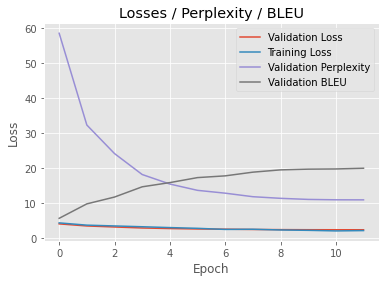

In [14]:
# plot losses and validation accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(range(0, hparams.epochs), valid_losses, label="Validation Loss")
plt.plot(range(0, hparams.epochs), train_losses, label="Training Loss")
plt.plot(range(0, hparams.epochs), valid_perplexities, label="Validation Perplexity")
plt.plot(range(0, hparams.epochs), valid_bleus, label="Validation BLEU")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.title("Losses / Perplexity / BLEU")
plt.show()

In [15]:
print("Qualitative Evaluation: Translating from Vietnamese to English")

expected_tgt_seq = "I like to read books."
print("Expected translation:")
print(expected_tgt_seq)
# From Google Translate
src_seq = "Tôi thích đọc sách kỹ thuật."
print("In Vietnamese (from Google Translate):")
print(src_seq)

translation_out = nmt.utils.translate_with_unk(
# translation_out = nmt.utils.translate(
    transformer_translator,
    src_seq,
    iwslt_src_vocab,
    iwslt_tgt_vocab,
    ctx)

print("The English translation is:")
print(" ".join(translation_out[0]))

Qualitative Evaluation: Translating from Vietnamese to English
Expected translation:
I like to read books.
In Vietnamese (from Google Translate):
Tôi thích đọc sách kỹ thuật.
The English translation is:
I like to read books and I like to read books books and I like to read books .
